In [3]:
# import pandas as pd
from functools import reduce #merging dfs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score,fbeta_score, log_loss, confusion_matrix, roc_auc_score, roc_curve, fbeta_score, make_scorer
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import pickle
import matplotlib as plot
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn import over_sampling
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from sklearn.compose import ColumnTransformer



from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

from mlxtend.classifier import StackingClassifier # <-- note: this is not from sklearn!
from sklearn.pipeline import Pipeline







#saving
#pickle.dump(master_df, open("master_df.pickle", "wb" ))

#reading df
#master_df=pickle.load(open("master_df.pickle", "rb"))


plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

pd.options.display.max_rows = 251


# Importing 

In [317]:
#neuropysch
neuropsych_df=pd.read_excel('mac_neuropsych.xlsx', sheet_name='mac_neuropsychmmse',
                           index_col=0)
#loose mask for filtering data with nulls
neuropsych_df=neuropsych_df[neuropsych_df['MMSETot']>=0]

In [318]:
#additional neuropsych
bedside_df=pd.read_excel ('mac_query.xlsx',
                          sheet_name='mac_bedsidescreen', index_col=0)
#masking data with nulls 
bedside_df=bedside_df[bedside_df['MMSETot']>=0]

In [319]:
#demographics
demo_df=pd.read_excel('mac_demo.xlsx', index_col=0)

In [320]:
#clinical dementia rating 
cdr_df=pd.read_excel('mac_cdr.xlsx', index_col=0)

In [321]:
#diagnosis 
dx_df=pd.read_excel ('mac_dxl.xlsx', sheet_name='mac_diagnosis', index_col=0)

# Filtering and merging

In [428]:
#can read in pickles instead of running importing chunks
neuropsych_df=pickle.load(open("neuropsych_df.pickle", "rb"))
bedside_df=pickle.load(open("bedside_df.pickle", "rb"))
demo_df=pickle.load(open("demo_df.pickle", "rb"))
cdr_df=pickle.load(open("cdr_df.pickle", "rb"))
dx_df=pickle.load(open("dx_df.pickle", "rb"))


In [429]:
#selecting only date and mmse data columns
col_names=list(bedside_df.iloc[:, np.r_[1, 15:44]].columns)

#masking to merge two datasets with mmse data and saved as mmse_df
mmse_df=neuropsych_df[col_names]
mmse_df=mmse_df.append(bedside_df[col_names])
mmse_df.shape

(32813, 30)

In [430]:
#saving cdr df as w only relevant columns
cdr_df=cdr_df[['DCDate','CDRTot']]
#finding those that are healthy but without a cdr score
norms=pd.DataFrame(dx_df[(dx_df['NORMAL']==5)|
            (dx_df['ClinSynBestEst']=='CLINICALLY NORMAL')|
            (dx_df['DxPrim']=='NORMAL')|
            (dx_df['Level1']=='NORMAL')|
            (dx_df['Level2']=='NORMAL')|
            (dx_df['Level3']=='NORMAL')|
            (dx_df['Level4']=='NORMAL')|
            (dx_df['Level5']=='NORMAL')|
            (dx_df['ResDxA']=='RECRUITED CONTROL NORMAL')]['DCDate'])
#merging the cdr and norms 
norms=pd.merge(cdr_df, norms, on = 'PIDN')

#filtering to only those where the data entries fall within 90 days-we can't assume that someone has the same cdr score at a different date
norms=norms[pd.to_datetime(norms.DCDate_x)-pd.to_datetime(norms.DCDate_y)<pd.Timedelta(90,'d')]



In [431]:

#setting cdr to zero for those that had a label of 'normal' if the cdr score is missing or if the cdr is negative(this also means the data were missing)
norms.loc[(norms['CDRTot']<0)|(norms['CDRTot'].isna()),'CDRTot']= 0

#renaming the date column we'll keep
norms=norms.iloc[:,0:2].rename(columns={'DCDate_x':'DCDate'})
#appending the norms dataframe to the cdr data frame
cdr_df=cdr_df.append(norms)
#dropping all data who do not have a cdr score or a negative cdr score (those were set to zero)
cdr_df=cdr_df[cdr_df['CDRTot']>=0].dropna()

#merging the mmse data to the newly modified df
master_df=pd.merge(mmse_df, cdr_df, on='PIDN', how='inner')
#keep only the data that matches date of the other dataframe's date

#drop this data since date was out of range
master_df.drop(index=32208, inplace=True)



In [432]:
master_df=master_df[pd.to_datetime(master_df.DCDate_x)-pd.to_datetime(master_df.DCDate_y)<pd.Timedelta(180,'d')]


In [433]:
longitudinal_df=master_df.drop_duplicates()

master_df=master_df.drop_duplicates().groupby('PIDN').last()


In [434]:
#merge master df and demographics df together
master_df=pd.merge(master_df,demo_df.iloc[:, np.r_[0,4:7]], on='PIDN')

In [435]:
#convert dob to datetime
master_df['DOB']=pd.to_datetime(master_df['DOB'])
#get diff from data collection date form bday and convert to years
master_df['age']=(master_df['DCDate_x']-master_df['DOB']) / np.timedelta64(1, 'Y')

In [436]:
master_df=master_df.dropna()

In [437]:
master_df=master_df.drop(['DCDate_x', 'DCDate_y', 'MMSETotalOnly', 'DOB'], axis=1)


In [438]:
#remove spaces
master_df['Hand']=master_df['Hand'].str.strip()

In [439]:
master_df["Hand"] = master_df["Hand"].astype('category')
#dementia score of 1 has dementia
master_df.loc[master_df['CDRTot']>=.5, 'Dementia']=1
master_df['Dementia']=master_df['Dementia'].fillna(0)
master_df['Dementia']=master_df['Dementia'].astype('category').cat.codes



In [440]:
master_df['Dementia']=master_df['Dementia'].fillna(0)

In [441]:
#2-right, 1-left,0-amb
master_df['Hand']=master_df["Hand"].cat.codes

In [442]:
#removing CDR scores as we're now using a binary classification of dementia, which was derived from this score
master_df.drop(['CDRTot'], axis=1, inplace=True)

# removing all data that has negative values-this will mess things up for naive bayes model 
master_df=master_df[master_df.select_dtypes(include=[np.number]).ge(0).all(1)]



## Load in dfs to use

In [35]:
####
#Load in the master_df pickle
####

master_df=pickle.load(open("master_df.pickle", "rb"))
#longitudinal_df=pickle.laod(open('longitudinal_df.pickle', 'rb'))


In [36]:
scaler = StandardScaler()
#X=pd.DataFrame(scaler.fit_transform(master_df.iloc[:,:-1]))
X=master_df.iloc[:,:-1]
y=master_df['Dementia']
#get column names to pass into pipes
col_names=X.columns

## define the data preparation for the model that need scaled data
t = [('scaler', StandardScaler(), col_names)]
col_transform = ColumnTransformer(transformers=t,remainder='passthrough')

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

#temp val split-will overwrite the train data with above split before cross val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                       test_size=.25,     
                                       random_state=42)


#Using this to score models during hyperparameter tuning
ftwo_scorer = make_scorer(fbeta_score, beta=2)

## kNN

In [37]:
knn_model = KNeighborsClassifier(n_neighbors= 50, p= 1, weights= 'uniform')
# define the data preparation and modeling pipeline
knn = Pipeline(steps=[('prep',col_transform), ('m', knn_model)])

#fit model 
knn.fit(X_train,y_train)

#roc curve
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])


####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
#find best threshold that balances fpr and tpr
knn_gmeans = np.sqrt(knn_tpr * (1-knn_fpr))
# locate the index of the largest g-mean
knn_ix = np.argmax(knn_gmeans)


# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
#for confusion matrices
knn_confusion = confusion_matrix(y_test, knn.predict(X_test))
knn_confusion_threshold = confusion_matrix(y_test, knn.predict_proba(X_test)[:,1]>knn_thresholds[knn_ix])




print('Base training f2:  0.883')
print('Base validation f2:  0.823')
print('')
print("Tuned training f2: {:6.3f}".format(fbeta_score(y_train,knn.predict(X_train), beta=2)))
print("Tuned validation f2: {:6.3f}".format(fbeta_score(y_val,knn.predict(X_val), beta=2)))
y_prob_pred_val = knn.predict_proba(X_val)[:,1]
y_predict = knn.predict(X_val)
print("Logloss: {:6.3f}".format(log_loss(y_val,y_prob_pred_val)))
print("f1: {:6.3f}".format(f1_score(y_val, y_predict)))
print("ROC AUC score: {:6.3}".format(roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])))
print('Best Threshold=%f, G-Mean=%.3f' % (knn_thresholds[knn_ix], knn_gmeans[knn_ix]))


Base training f2:  0.883
Base validation f2:  0.823

Tuned training f2:  0.787
Tuned validation f2:  0.780
Logloss:  0.481
f1:  0.824
ROC AUC score:   0.84
Best Threshold=0.480000, G-Mean=0.763


## Logistic regression

[logloss (cross entropy) explanation](https://www.kaggle.com/dansbecker/what-is-log-loss)

In [38]:
# define the model
log_model = LogisticRegression(C=0.01, solver='lbfgs')
# define the data preparation and modeling pipeline
logit = Pipeline(steps=[('prep',col_transform), ('m', log_model)])

#fit model to train data
logit.fit(X_train,y_train)

#for roc plot
log_fpr, log_tpr, log_thresholds = roc_curve(y_test, logit.predict_proba(X_test)[:,1])


####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
#find best threshold that balances fpr and tpr
log_gmeans = np.sqrt(log_tpr * (1-log_fpr))
# locate the index of the largest g-mean
log_ix = np.argmax(log_gmeans)
#for conf matrices

#for conf matrices
log_confusion = confusion_matrix(y_test, logit.predict(X_test))
log_confusion_threshold = confusion_matrix(y_test, logit.predict_proba(X_test)[:,1]>log_thresholds[log_ix])



print('Base training f2:  0.868')
print('Base validation f2:  0.849')
print('')
print("Tuned training f2: {:6.3f}".format(fbeta_score(y_train,logit.predict(X_train), beta=2)))
print("Tuned validation f2: {:6.3f}".format(fbeta_score(y_val,logit.predict(X_val), beta=2)))
y_prob_pred_val = logit.predict_proba(X_val)[:,1]
y_predict = logit.predict(X_val)
print("Logloss: {:6.3f}".format(log_loss(y_val,y_prob_pred_val)))
print("f1: {:6.3f}".format(f1_score(y_val, y_predict)))
print("ROC AUC score: {:6.3}".format(roc_auc_score(y_test, logit.predict_proba(X_test)[:,1])))
print('Best Threshold=%f, G-Mean=%.3f' % (log_thresholds[log_ix], log_gmeans[log_ix]))

Base training f2:  0.868
Base validation f2:  0.849

Tuned training f2:  0.877
Tuned validation f2:  0.865
Logloss:  0.412
f1:  0.852
ROC AUC score:  0.848
Best Threshold=0.649884, G-Mean=0.768


# Tree models

In [39]:

randomforest = RandomForestClassifier(bootstrap=True,
                                      max_depth= 5, 
                                      max_features= 'auto',
                                      n_estimators= 50)

randomforest.fit(X_train,y_train)



#roc curve
forest_fpr, forest_tpr, forest_thresholds = roc_curve(y_test, randomforest.predict_proba(X_test)[:,1])

####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
#find best threshold that balances fpr and tpr
forest_gmeans = np.sqrt(forest_tpr * (1-forest_fpr))
# locate the index of the largest g-mean
forest_ix = np.argmax(forest_gmeans)


#confusion matrix w/threshold
forest_confusion_threshold = confusion_matrix(y_test, 
                                              randomforest.predict_proba(X_test)[:,1]>forest_thresholds[forest_ix])
#confusion matrix 
forest_confusion = confusion_matrix(y_test, randomforest.predict(X_test))



print("Base training f2: 1.000")
print("Base validation f2: 0.866")
print('')
print("Tuned training f2: {:6.3f}".format(fbeta_score(y_train,randomforest.predict(X_train), beta=2)))
print("Tuned validation f2: {:6.3f}".format(fbeta_score(y_val,randomforest.predict(X_val), beta=2)))
y_prob_pred_val = randomforest.predict_proba(X_val)[:,1]
y_predict = randomforest.predict(X_val)
print("Logloss: {:6.3f}".format(log_loss(y_val,y_prob_pred_val)))
print("f1: {:6.3f}".format(f1_score(y_val, y_predict)))
print("Tuned ROC AUC score:{:6.3}".format(roc_auc_score(y_test, randomforest.predict_proba(X_test)[:,1])))
print('Best Threshold=%f, G-Mean=%.3f' % (forest_thresholds[forest_ix], forest_gmeans[forest_ix]))

Base training f2: 1.000
Base validation f2: 0.866

Tuned training f2:  0.880
Tuned validation f2:  0.870
Logloss:  0.414
f1:  0.859
Tuned ROC AUC score: 0.853
Best Threshold=0.669300, G-Mean=0.784


# BOOST

In [40]:
#instantiate boosted model with recommended hps 
gbm = xgb.XGBClassifier(n_estimators=180,
                    max_depth=2,
                    objective='binary:logistic', #new objective
                    learning_rate=.05, 
                    subsample=1,
                    min_child_weight=1,
                    colsample_bytree=.8,
                    use_label_encoder=False,
                    gamma=1.5)


eval_set=[(X_train,y_train),(X_val,y_val)]
gbm.fit(X_train, y_train, 
        eval_set=eval_set,
        eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
        early_stopping_rounds=10,
        verbose=False)




#roc curve
gbm_fpr, gbm_tpr, gbm_thresholds = roc_curve(y_test, gbm.predict_proba(X_test)[:,1])

####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
#find best threshold that balances fpr and tpr
gbm_gmeans = np.sqrt(gbm_tpr * (1-gbm_fpr))
# locate the index of the largest g-mean
gbm_ix = np.argmax(gbm_gmeans)


#confusion matrix
boost_confusion_threshold = confusion_matrix(y_test, gbm.predict_proba(X_test)[:,1]>gbm_thresholds[gbm_ix])
boost_confusion = confusion_matrix(y_test, gbm.predict(X_test))




print("Base training f2:  0.893")
print("Base validation f2:  0.865")
print("")
print("Tuned boost training f2: {:6.3f}".format(fbeta_score(y_train,gbm.predict(X_train), beta=2)))
print("Tuned boost validation f2: {:6.3f}".format(fbeta_score(y_val,gbm.predict(X_val), beta=2)))
#calc log loss (1-* likelihood function)
y_prob_pred_val = gbm.predict_proba(X_val)[:,1]
y_predict = gbm.predict(X_val)
print("Tuned logloss: {:6.3f}".format(log_loss(y_val,y_prob_pred_val)))
print("Tuned f1: {:6.3f}".format(f1_score(y_val, y_predict)))
print("Tuned ROC AUC score:{:6.3}".format(roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1])))
print('Best Threshold=%f, G-Mean=%.3f' % (gbm_thresholds[gbm_ix], gbm_gmeans[gbm_ix]))

Base training f2:  0.893
Base validation f2:  0.865

Tuned boost training f2:  0.868
Tuned boost validation f2:  0.859
Tuned logloss:  0.418
Tuned f1:  0.855
Tuned ROC AUC score: 0.848
Best Threshold=0.663992, G-Mean=0.776


## Ensebling 

In [41]:
model_list=[knn,logit,randomforest,gbm]
model_names = ["knn", "logit", "randomforest", "gbm"]


model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

voting = VotingClassifier(estimators=model_list,
                                    voting='soft',
                                    n_jobs=-1)

voting.fit(X_train, y_train)

fbeta_score(y_val,voting.predict(X_val), beta =2)



#roc curve
voting_fpr, voting_tpr, voting_thresholds = roc_curve(y_test, voting.predict_proba(X_test)[:,1])

####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
#find best threshold that balances fpr and tpr
voting_gmeans = np.sqrt(voting_tpr * (1-voting_fpr))
# locate the index of the largest g-mean
voting_ix = np.argmax(voting_gmeans)


#confusion matrix
voting_confusion_threshold = confusion_matrix(y_test, voting.predict_proba(X_test)[:,1]>voting_thresholds[voting_ix])
voting_confusion = confusion_matrix(y_test, voting.predict(X_test))





print("Voting training f2: {:6.3f}".format(fbeta_score(y_train,voting.predict(X_train), beta=2)))
print("Voting validation f2: {:6.3f}".format(fbeta_score(y_val,voting.predict(X_val), beta=2)))
#calc log loss (1-* likelihood function)
y_prob_pred_val = voting.predict_proba(X_val)[:,1]
y_predict = voting.predict(X_val)
print("Tuned logloss: {:6.3f}".format(log_loss(y_val,y_prob_pred_val)))
print("Tuned f1: {:6.3f}".format(f1_score(y_val, y_predict)))
print("Tuned ROC AUC score:{:6.3}".format(roc_auc_score(y_test, voting.predict_proba(X_test)[:,1])))
print('Best Threshold=%f, G-Mean=%.3f' % (voting_thresholds[voting_ix], voting_gmeans[voting_ix]))

Voting training f2:  0.872
Voting validation f2:  0.859
Tuned logloss:  0.410
Tuned f1:  0.857
Tuned ROC AUC score: 0.854
Best Threshold=0.613519, G-Mean=0.777


# Plots

kNN ROC AUC score =  0.840
ROC AUC score =  0.848
Random Forest ROC AUC score =  0.853
Boosted ROC AUC score =  0.848
Tuned ROC AUC score: 0.854


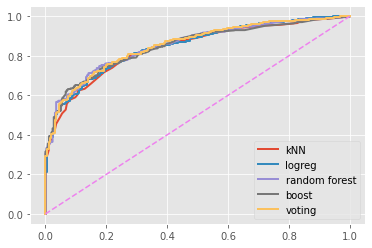

In [42]:
#kNN
plt.plot(knn_fpr, knn_tpr,lw=2)
# logreg
plt.plot(log_fpr, log_tpr,lw=2)
# random forest
plt.plot(forest_fpr, forest_tpr,lw=2)
#boost
plt.plot(gbm_fpr, gbm_tpr,lw=2)
#voting
plt.plot(voting_fpr, voting_tpr,lw=2)



#linear reference line
plt.plot([0,1],[0,1],c='violet',ls='--')


plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(['kNN','logreg','random forest', 'boost', 'voting'])

print("kNN ROC AUC score = {:6.3f}".format(roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])))
print("ROC AUC score = {:6.3}".format(roc_auc_score(y_test, logit.predict_proba(X_test)[:,1])))
print("Random Forest ROC AUC score = {:6.3f}".format(roc_auc_score(y_test, randomforest.predict_proba(X_test)[:,1])))
print("Boosted ROC AUC score = {:6.3f}".format(roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1])))
print("Tuned ROC AUC score:{:6.3}".format(roc_auc_score(y_test, voting.predict_proba(X_test)[:,1])))





In [43]:


print("Tuned kNN training f2: {:6.3f}".format(fbeta_score(y_train,knn.predict(X_train), beta=2)))
print("Tuned kNN validation f2: {:6.3f}".format(fbeta_score(y_val,knn.predict(X_val), beta=2)))
print('')
print("Tuned logreg training f2: {:6.3f}".format(fbeta_score(y_train,logit.predict(X_train), beta=2)))
print("Tuned logreg validation f2: {:6.3f}".format(fbeta_score(y_val,logit.predict(X_val), beta=2)))
print('')
print("Tuned forest training f2: {:6.3f}".format(fbeta_score(y_train,randomforest.predict(X_train), beta=2)))
print("Tuned forest validation f2: {:6.3f}".format(fbeta_score(y_val,randomforest.predict(X_val), beta=2)))
print('')
print("Tuned boost training f2: {:6.3f}".format(fbeta_score(y_train,gbm.predict(X_train), beta=2)))
print("Tuned boost validation f2: {:6.3f}".format(fbeta_score(y_val,gbm.predict(X_val), beta=2)))
print('')
print("Voting training f2: {:6.3f}".format(fbeta_score(y_train,voting.predict(X_train), beta=2)))
print("Voting validation f2: {:6.3f}".format(fbeta_score(y_val,voting.predict(X_val), beta=2)))
print('')
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
print("Bayes training f2: {:6.3f}".format(fbeta_score(y_train,clf.predict(X_train), beta=2)))
print("Bayes validation f2: {:6.3f}".format(fbeta_score(y_val,clf.predict(X_val), beta=2)))


Tuned kNN training f2:  0.787
Tuned kNN validation f2:  0.780

Tuned logreg training f2:  0.877
Tuned logreg validation f2:  0.865

Tuned forest training f2:  0.880
Tuned forest validation f2:  0.870

Tuned boost training f2:  0.868
Tuned boost validation f2:  0.859

Voting training f2:  0.872
Voting validation f2:  0.859

Bayes training f2:  0.767
Bayes validation f2:  0.736


# Stacked ensemble

In [44]:

stacked = StackingClassifier(
    classifiers=model_vars, meta_classifier=LogisticRegression(), use_probas=False)
stacked.fit(X_train, y_train)
print("Voting training f2: {:6.3f}".format(fbeta_score(y_train,stacked.predict(X_train), beta=2)))
print("Voting validation f2: {:6.3f}".format(fbeta_score(y_val,stacked.predict(X_val), beta=2)))


[22:21:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Voting training f2:  0.883
Voting validation f2:  0.870


# knn tuning

In [29]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
#Oversampling healthy controls-------THIS MADE MODELS PERFORM WORSE
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio={1 : n_pos, 0 : n_neg*2} 
# randomly oversample positive samples: create 2.8x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
X_rs, y_rs = ROS.fit_resample(X_train, y_train)


smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    
X_tr_smote, y_tr_smote = smote.fit_resample(X_train, y_train)

In [30]:
knn_model = KNeighborsClassifier()
# define the data preparation and modeling pipeline
knn = Pipeline(steps=[('prep',col_transform), ('m', knn_model)])


knn.fit(X_rs,y_rs)
print(fbeta_score(y_val,knn.predict(X_val), beta=2))

knn_model = KNeighborsClassifier()
# define the data preparation and modeling pipeline
knn = Pipeline(steps=[('prep',col_transform), ('m', knn_model)])


knn.fit(X_tr_smote,y_tr_smote)
print(fbeta_score(y_val,knn.predict(X_val), beta=2))



0.7473481195756991
0.7591287636130687


In [463]:


k_range = list(range(1, len(X_train), 50))
k_scores = []
k_scores_dict=dict()
for k in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    # define the data preparation and modeling pipeline
    knn = Pipeline(steps=[('prep',col_transform), ('m', knn_model)])
    #change the scoring param if using this
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring=ftwo_scorer, n_jobs=-1)
    k_scores.append(scores.mean())
    k_scores_dict[k]=scores.mean()

1201 0.930630430120073


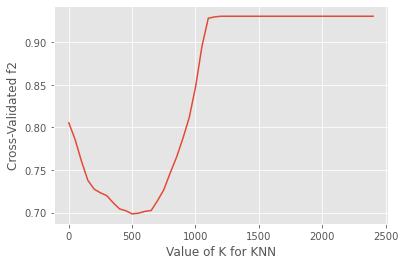

In [464]:
#visualize above code number of neighbors
best_k=max(k_scores_dict, key=k_scores_dict.get)
print(best_k,k_scores_dict[best_k])

import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated f2')
plt.savefig('knn_cv_accuracy.png')

# kNN tuning


In [24]:

knn = KNeighborsClassifier()
# define the parameter values that should be searched
k_range = list(range(1, 1000, 25))
# create a parameter grid: map the parameter names to the values that should be searched
weight_options = ['uniform', 'distance']
#Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), 
#and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.
ps=[1,2]
param_grid = dict(n_neighbors=k_range, weights=weight_options, p=ps)
#the higher we set beta to, the more the model will weigh recall over precision-
ftwo_scorer = make_scorer(fbeta_score, beta=2)
# instantiate the grid
knn_grid = RandomizedSearchCV(knn, param_grid, cv=5, scoring=ftwo_scorer, n_jobs=1)
#fit model
knn_grid.fit(scaler.fit_transform(X_train), y_train)
# view the complete results if desired
knn_grid.cv_results_

# examine the best model
print("Best params: ", knn_grid.best_params_)
print("Best estimator: ", knn_grid.best_estimator_)
print("Best score: ", knn_grid.best_score_)


fbeta_score(y_val,knn_grid.predict(scaler.transform(X_val)), beta=2)


ValueError: Invalid parameter weights for estimator Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  Index(['Year', 'Season', 'Month', 'Date', 'Day', 'Place', 'Floor', 'City',
       'County', 'State', 'RepBall', 'RepFlag', 'RepTree', 'Trials', 'World',
       'RemBall', 'RemFlag', 'RemTree', 'Watch', 'Pencil', 'NoIfs', 'HandPap',
       'FoldPap', 'OnFloor', 'Eyes', 'Sent', 'Pentgon', 'MMSETot', 'Hand',
       'Gender', 'Educ', 'age'],
      dtype='object'))])),
                ('m', KNeighborsClassifier(n_neighbors=50, p=1))]). Check the list of available parameters with `estimator.get_params().keys()`.

# logreg tuning

In [502]:
# grid search 
logit =  LogisticRegression(max_iter=5000)#,class_weight={0:2, 1:1})

#Inverse of regularization strength get warning below if above 1
### ConvergenceWarning: lbfgs failed to converge (status=1):STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
Cs=[0.01,0.1,1,10,100,1000,10000,100000,1000000]

#solver
solve=['lbfgs', 'liblinear']


param_grid = dict(C=Cs, solver=solve)
# instantiate the grid
log_grid = RandomizedSearchCV(logit, param_grid, cv=5, scoring=ftwo_scorer)
#fbeta wiegh for recall
#fit model
log_grid.fit(scaler.fit_transform(X_train), y_train);
# view the complete results
log_grid.cv_results_

# examine the best model
print("Best params: ", log_grid.best_params_)
print("Best estimator: ", log_grid.best_estimator_)
print("Best score: ", log_grid.best_score_)
print(fbeta_score(y_val,log_grid.predict(scaler.transform(X_val)), beta=2))



#look at what features are highly influencial-lower log loss
alist=[]
for col in X_train.columns:
    X_tr = X_train[[col]]
    X_te = X_test[[col]]
    lr_model = LogisticRegression(C=.01,solver='lbfgs')
    lr_model.fit(scaler.fit_transform(X_tr),y_train)
    y_prob_pred_test = lr_model.predict_proba(scaler.transform(X_te))[:,1]
    alist.append(log_loss(y_test,y_prob_pred_test))
    
adf = pd.DataFrame(alist, columns=["logloss"])
#tried model with the features below-didn't really perform better
#adf[adf['logloss']<.5]





Best params:  {'solver': 'lbfgs', 'C': 0.01}
Best estimator:  LogisticRegression(C=0.01, max_iter=5000)
Best score:  0.8754973697623012
0.8653550568705811


In [ ]:
master_df.iloc[:,:-1]

# Random forest tuning 

In [32]:

randomforest = RandomForestClassifier()
#n_estimators
#estimators=list(range(100,1010, 100))
#max_depth
#depth=list(range(1,20,10))
#min_samples_split
#min_samp_split=list(range(2,50,10))
#min_samples_leaf
#min_samp_leaf=list(range(2,50,10))

param_grid = {'bootstrap': [True], 
              'max_depth': [5, 10, None],
              'max_features': ['auto', 'log2'],
              'n_estimators': list(range(50,500,100))}

# instantiate the grid
forest_grid = RandomizedSearchCV(randomforest, param_grid, cv=5, scoring=ftwo_scorer)
forest_grid.fit(X_train,y_train)




print("Best params: ", forest_grid.best_params_)
print("Best estimator: ", forest_grid.best_estimator_)
print("Best score: ", forest_grid.best_score_)

print("Base training: 1.000")
print("Base training: 0.866")

print("Training: {:6.3f}".format(fbeta_score(y_train,forest_grid.predict(X_train), beta=2)))
print("Test set: {:6.3f}".format(fbeta_score(y_val,forest_grid.predict(X_val), beta=2)))



importances=forest_grid.feature_importances_
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
std = np.std([tree.feature_importances_ for tree in forest_grid.estimators_], axis=0)



forest_importances = pd.Series(importances, index=feature_names)


plt.subplots()


forest_importances.plot.bar(yerr=std, figsize=(10,10))



Best params:  {'n_estimators': 350, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
Best estimator:  RandomForestClassifier(n_estimators=350)
Best score:  0.8829329653344742
Base training: 1.000
Base training: 0.866
Training:  1.000
Test set:  0.874


AttributeError: 'RandomizedSearchCV' object has no attribute 'feature_importances_'

## Tuning XGB using randomized search CV

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Training:  0.868
Validation:  0.829


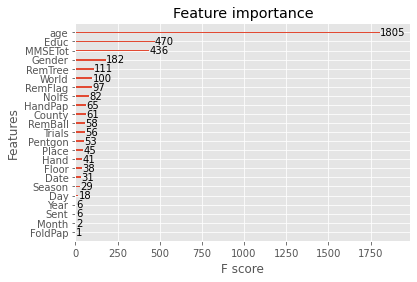

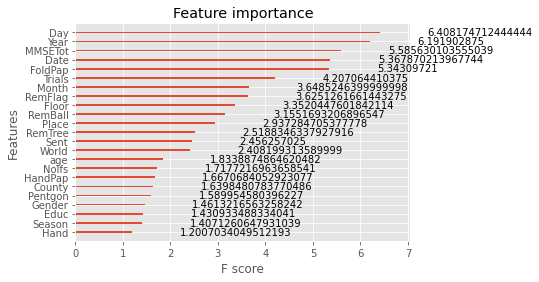

In [33]:
X=master_df.iloc[:,:-1]
#X=X[['age','Educ','MMSETot','Gender']]
y=master_df['Dementia']
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)
#temp val split-will overwrite the train data with above split before cross val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                       test_size=.25,     
                                       random_state=42)

gbm = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=-1,
    seed=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=.5
)

parameters = {
    'max_depth': range (1, 20, 1),
    'n_estimators': range(10, 300, 20),
    'learning_rate': [0.1, 0.01, 0.05],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]}



random_search = RandomizedSearchCV(gbm,
                                   param_distributions=parameters,
                                   n_iter=5, scoring=ftwo_scorer,
                                   n_jobs=4, cv=5, 
                                   verbose=3, random_state=42)

#f1

random_search.fit(X_train, y_train)

print("Training: {:6.3f}".format(fbeta_score(y_train,random_search.predict(X_train), beta=2)))
print("Validation: {:6.3f}".format(fbeta_score(y_val,random_search.predict(X_val), beta=2)))



gbm_p=xgb.XGBClassifier(**random_search.best_params_, use_label_encoder=False,eval_metric='logloss')
gbm_p.fit(X_train,y_train)
xgb.plot_importance(gbm_p)
plt.savefig('importance.png')
xgb.plot_importance(gbm_p, importance_type='gain')
plt.savefig('gain_importance.png')



#just age, mmsetot,educ, gender 
#Training:  0.818
#Validation:  0.807



In [576]:
random_search.best_score_

0.8221261187389135

In [577]:
random_search.score(X_train, y_train)

0.8682697334030318

In [578]:
#random_search.cv_results_

In [579]:
cross_val_score(test, X_train, y_train, cv=5, scoring=ftwo_scorer).mean()

0.8221261187389135

In [555]:
fbeta_score(y_train,test.predict(X_train), beta=2)

0.8682697334030318

In [548]:
fbeta_score(y_train,random_search.predict(X_train), beta=2)

0.8682697334030318

In [547]:
fbeta_score(y_train,gbm_p.predict(X_train),beta=2)

0.9365759151626389

In [551]:
test=xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=-1,
    seed=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=.5,
    subsample= 0.6,
    n_estimators= 210,
    min_child_weight= 5,
    max_depth= 10,
    learning_rate= 0.1,
    gamma= 0.5,
    colsample_bytree= 0.6)

In [559]:
test#.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='logloss',
              gamma=0.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=10, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=210, n_jobs=4, nthread=-1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.5, seed=42, subsample=0.6, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [15]:
0.883-0.823


0.06000000000000005

In [19]:
0.873-0.857






0.016000000000000014